In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

from rotations import Quaternion, skew_symmetric
from vis_tools import *

import cv2
import glob
import os

%matplotlib inline


## Visualization method

### Loading the ground_truth dataframe

In [2]:
df = pd.read_csv('data/ground_truth/gt_1.csv')

In [3]:
df.head()

,%time,field.header.seq,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,2767042000000,0,2767038000000,map,base_link,-2.667829e-10,-0.000002,3.463433e-07,0.000005,-7.756899e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2767074000000,1,2767074000000,map,base_link,-2.622925e-10,-0.000002,3.481283e-07,0.000005,-7.604584e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2767110000000,2,2767110000000,map,base_link,-2.594918e-10,-0.000002,3.498753e-07,0.000005,-7.509184e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2767146000000,3,2767146000000,map,base_link,-2.587419e-10,-0.000002,3.516112e-07,0.000005,-7.482835e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2767182000000,4,2767182000000,map,base_link,-2.598274e-10,-0.000002,3.533459e-07,0.000005,-7.518286e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df.drop(columns=['%time', 'field.header.seq'])
df.head()

,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,2767038000000,map,base_link,-2.667829e-10,-0.000002,3.463433e-07,0.000005,-7.756899e-10,-8.347211e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2767074000000,map,base_link,-2.622925e-10,-0.000002,3.481283e-07,0.000005,-7.604584e-10,-8.351686e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2767110000000,map,base_link,-2.594918e-10,-0.000002,3.498753e-07,0.000005,-7.509184e-10,-8.356080e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2767146000000,map,base_link,-2.587419e-10,-0.000002,3.516112e-07,0.000005,-7.482835e-10,-8.360472e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2767182000000,map,base_link,-2.598274e-10,-0.000002,3.533459e-07,0.000005,-7.518286e-10,-8.364861e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
pos_features = ['field.pose.pose.position.x', 'field.pose.pose.position.y', 'field.pose.pose.position.z']
orientation_features = ['field.pose.pose.orientation.x', 'field.pose.pose.orientation.y', 
                       'field.pose.pose.orientation.z', 'field.pose.pose.orientation.w']

In [6]:
position = df[pos_features]
position.head()

,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z
0,-2.667829e-10,-0.000002,3.463433e-07
1,-2.622925e-10,-0.000002,3.481283e-07
2,-2.594918e-10,-0.000002,3.498753e-07
3,-2.587419e-10,-0.000002,3.516112e-07
4,-2.598274e-10,-0.000002,3.533459e-07


In [7]:
list_of_pos = position.values.tolist()
list_of_pos = np.array(list_of_pos).T

### Plotting trajectory

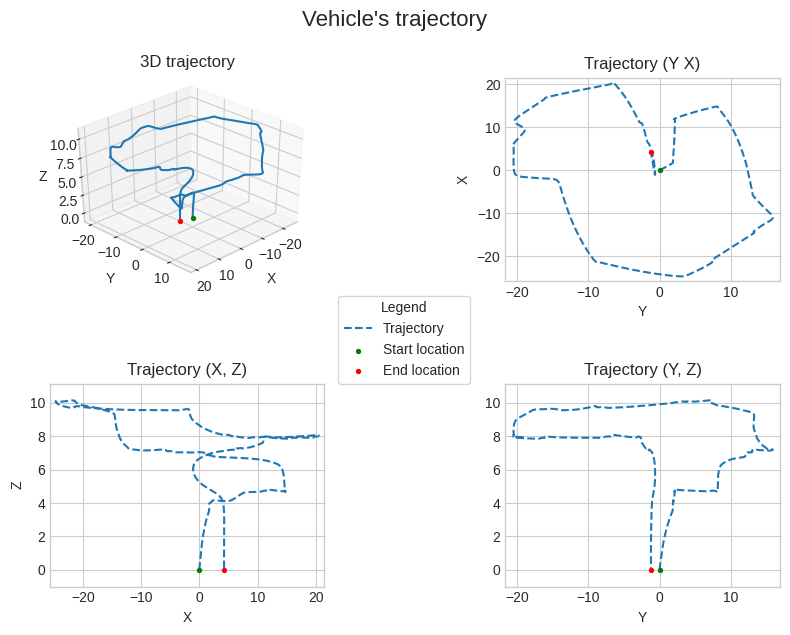

In [8]:
visualize_trajectory(position)

Read Chapter 6, Sections 1 to 3. Section 6.4 is about essential matrix
http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf
Read Section 5 of a technical report by
https://arxiv.org/pdf/1711.02508.pdf

## 3D Geometry

To understand reference frames, this little sections aims to make clear the basic concepts. The next figure will be used to give a basic notation and properties of rotation matrices.

<img src='assets/rotationsT.png' width=320 />

### Vectors and reference frames

The notation of a coordinate frame is given by $\underrightarrow{\boldsymbol{\mathcal{F}}}_i$ where $i$ is the current coordinate frame. Similarly, $\underrightarrow{\boldsymbol{r}}^{vi}$ is a three position vector that points from coordinate frame $i$ to $v$. The equation gives shows the three points in a position vector.

\begin{equation}
    r_i = \begin{bmatrix} r_1 \\ r_2 \\ r_3 \end{bmatrix}
\end{equation}

It is possible to do operations with position vectors. The dot product between two vector $\underrightarrow{r}$ and $\underrightarrow{s}$

\begin{equation}
    \underrightarrow{\boldsymbol{r}} \cdot \underrightarrow{\boldsymbol{s}} = \underrightarrow{\boldsymbol{r}}^T \cdot \underrightarrow{\boldsymbol{s}} = r_1s_1 + r_2s_2 + r_3s_2
\end{equation}

The cross product between two vector $\underrightarrow{r}$ and $\underrightarrow{s}$

\begin{equation}
    \underrightarrow{\boldsymbol{r}} \times \underrightarrow{\boldsymbol{s}} = \boldsymbol{r}_i^{\times}\boldsymbol{s}_i
\end{equation}

Where $\boldsymbol{r}_i^{\times}$ is the skew symetric. The skew symetris has a set of properties such as $(\boldsymbol{r}_i^{\times})^T = -\boldsymbol{r}_1^{\times}$

\begin{equation}
    \boldsymbol{r}_1^{\times} = \begin{pmatrix} 0 & -r_3 & r_2 \\ r_3 & 0 & -r_1 \\  -r_2 & r_1 & 0 \end{pmatrix}
\end{equation}

### Rotations

Rotations matrices are used to describe the relative orientation of one reference frame with respect to other. These matrices are denoted as $\boldsymbol{c}_{iv} \in \mathbb{R}^{3 \times 3}$ and it means that this rotation matrix comes from frame $i$ to frame $v$.

\begin{equation}
    \boldsymbol{c}_{iv} = \begin{pmatrix} c_{11} & c_{12} & c_{13} \\ c_{21} & c_{22} & c_{23} \\  c_{31} & c_{32} & c_{33} \end{pmatrix}
\end{equation}

Rotation matrices are orthogonal matrices, which means that their inverse is equal to its transpose $\boldsymbol{c}_{vi} = \boldsymbol{c}_{iv}^{-1} = \boldsymbol{c}_{iv}^{T}$. Using rotation matrices is possible to map points between different reference frames. Supposing that frame $i$ and $v$ are in the same position but with different orientation, point $p$ could be mapped as follows.

\begin{equation}
    r_i^{pi} = \boldsymbol{c}_{vi}^{-1} r_v^{pv} = \boldsymbol{c}_{iv} r_v^{pv}
\end{equation}

It is possible to perform operations between rotation matrices as follows.

\begin{equation}
    r_3 = \boldsymbol{c}_{32} r_2 = \boldsymbol{c}_{32} \boldsymbol{c}_{21} r_1
\end{equation}

\begin{equation}
    r_3 = \boldsymbol{c}_{31} r_1
\end{equation}

\begin{equation}
    \boldsymbol{c}_{31} = \boldsymbol{c}_{32} \boldsymbol{c}_{21}
\end{equation}

To map a point between reference frames in different positions use the next relation.

\begin{equation}
    \boldsymbol{r}_i^{pi} = \boldsymbol{r}_{i}^{vi} + \boldsymbol{c}_{iv} \boldsymbol{r}_{v}^{pv} 
\end{equation}

### Principal rotations

Rotation on each axis roll x $\theta$, pitch y $\beta$ and yaw z $\gamma$ are the principal rotations and are shown below.

\begin{equation}
    \boldsymbol{c}(\gamma) = \begin{pmatrix} cos(\gamma) & sin(\gamma) & 0 \\ -sin(\gamma) & cos(\gamma) & 0 \\  0 & 0 & 1 \end{pmatrix}, \boldsymbol{c}(\beta) = \begin{pmatrix} cos(\beta) & 0 & -sin(\beta) \\ 0 & 1 & 0 \\  sin(\beta) & 0 & cos(\beta) \end{pmatrix}, \boldsymbol{c}(\theta) = \begin{pmatrix} 1 & 0 & 0 \\ 0 & cos(\theta) & sin(\theta) \\  0 & -sin(\theta) & cos(\theta) \end{pmatrix}
\end{equation}

These rotations can be multiplied in the next form and create another form to represent rotations called Euler angles.

\begin{equation}
    \boldsymbol{c}(\gamma, \beta, \theta) =  \boldsymbol{c}_3(\gamma) \boldsymbol{c}_2(\beta) \boldsymbol{c}_1(\theta)
\end{equation}

### Quaternions

Quaternions are a different form to represent orientations. The parameters $\epsilon \in \mathbb{R}^{3 \times 1}$ and $\eta \in \mathbb{1}$ conform them. Below is the equation of a Quaternion where $\eta = cos(\phi/2)$ and $\epsilon = \hat{u} sin(\phi/2)$.

\begin{equation}
    \boldsymbol{q} = \begin{bmatrix} \epsilon \\ \eta \end{bmatrix} \in \mathbb{R}^{4 \times 1}
\end{equation}

Some of their properties is: $||q|| = 1$, $\boldsymbol{q}^T \boldsymbol{q} = 1$ and its inverse is given by

\begin{equation}
    \boldsymbol{q}^{-1} = \begin{bmatrix} -\epsilon \\ \eta \end{bmatrix} \in \mathbb{R}^{4 \times 1}
\end{equation}

It is possible to transform a Quaternion into a rotation matrix with the next equations.

\begin{equation}
    \boldsymbol{r}_b = \boldsymbol{C}(\boldsymbol{q}_{ba})\boldsymbol{r}_a
\end{equation}

\begin{equation}
    \boldsymbol{C}(q) = (\eta^2 - \boldsymbol{\epsilon}^T\boldsymbol{\epsilon})\mathbb{I} + 2\boldsymbol{\epsilon}\boldsymbol{\epsilon}^T + 2\eta[\boldsymbol{\epsilon}]_{\times}
\end{equation}

Similarly, the product between two quaternions is given as follows.

\begin{equation}
    \boldsymbol{p} \otimes \boldsymbol{q}  = \begin{bmatrix} \boldsymbol{p}_\eta \boldsymbol{q}_\eta - \boldsymbol{p}_\epsilon^T \boldsymbol{q}_\epsilon \\ \boldsymbol{p}_\eta\boldsymbol{q}_\epsilon + \boldsymbol{q}_\eta \boldsymbol{p}_\epsilon + [\boldsymbol{p}_\epsilon]_{\times} \boldsymbol{q}_\epsilon \end{bmatrix}
\end{equation}

### Transformation matrices

These is a compact form to represent rotations + traslations between reference frames. One property of Transformation matrices is $\boldsymbol{T}_{iv} = \boldsymbol{T}_{ia} \boldsymbol{T}_{ab} \boldsymbol{T}_{bv}$, which is exactly the same of rotation matrices.

To map a point between different coordinate frames, the relation is given as follows.

\begin{equation}
    \begin{bmatrix} r_i^{pi} \\ 1 \end{bmatrix} = \begin{pmatrix} \boldsymbol{c}_{iv} & \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} \begin{bmatrix} r_v^{pv} \\ 1 \end{bmatrix} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
\end{equation}

Some of their properties are given below.

\begin{equation}
    \begin{bmatrix} r_v^{pv} \\ 1 \end{bmatrix} = \boldsymbol{T}_{iv}^{-1} \begin{bmatrix} r_i^{pi} \\ 1 \end{bmatrix} = \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
\end{equation}

\begin{equation}
    \boldsymbol{T}_{iv}^{-1} = \begin{pmatrix} \boldsymbol{c}_{iv} & \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix}^{-1} = \begin{pmatrix} \boldsymbol{c}_{iv}^T & -\boldsymbol{c}_{iv}^T \boldsymbol{r}_i^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} = \begin{pmatrix} \boldsymbol{c}_{vi} & -\boldsymbol{r}_v^{vi} \\ \boldsymbol{0} & 1 \end{pmatrix} = \begin{pmatrix} \boldsymbol{c}_{vi} & \boldsymbol{r}_v^{iv} \\ \boldsymbol{0} & 1 \end{pmatrix} = \boldsymbol{T}_{vi}
\end{equation}

For further information about 3D Geometry and transformations between quaternions and other rotations' representations, see Chapter 6, Sections 1 to 3 [State estimation for Robotics](http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf)

In [9]:
orientation = df[orientation_features]
orientation.head()

,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w
0,0.000005,-7.756899e-10,-8.347211e-12,1.0
1,0.000005,-7.604584e-10,-8.351686e-12,1.0
2,0.000005,-7.509184e-10,-8.356080e-12,1.0
3,0.000005,-7.482835e-10,-8.360472e-12,1.0
4,0.000005,-7.518286e-10,-8.364861e-12,1.0


In [10]:
# Creating one quaternion
list_of_q = orientation.values.tolist()
list_of_q = np.array(list_of_q).T
q_1 = list_of_q[:,0]
q = Quaternion(w=q_1[3], x=q_1[0], y=q_1[1], z=q_1[2])
q

Quaternion (wxyz): [1.00000, 0.00001, -0.00000, -0.00000]

In [11]:
# Print rotation matrix
q.to_mat()

array([[0.9999999999994867, array([1.66859968e-11]),
        array([-1.55137997e-09])],
       [array([-1.67028453e-11]), 0.9999999999405133,
        array([-1.08603432e-05])],
       [array([1.55137978e-09]), array([1.08603432e-05]),
        0.9999999999405133]], dtype=object)

In [12]:
# Print euler angles, roll pitch and yaw
q.to_euler()

array([ 1.08603432e-05, -1.55137978e-09, -1.67028453e-11])

In [13]:
q = Quaternion(euler=q.to_euler())
q

Quaternion (wxyz): [1.00000, 0.00001, -0.00000, -0.00000]

### Plotting orientation

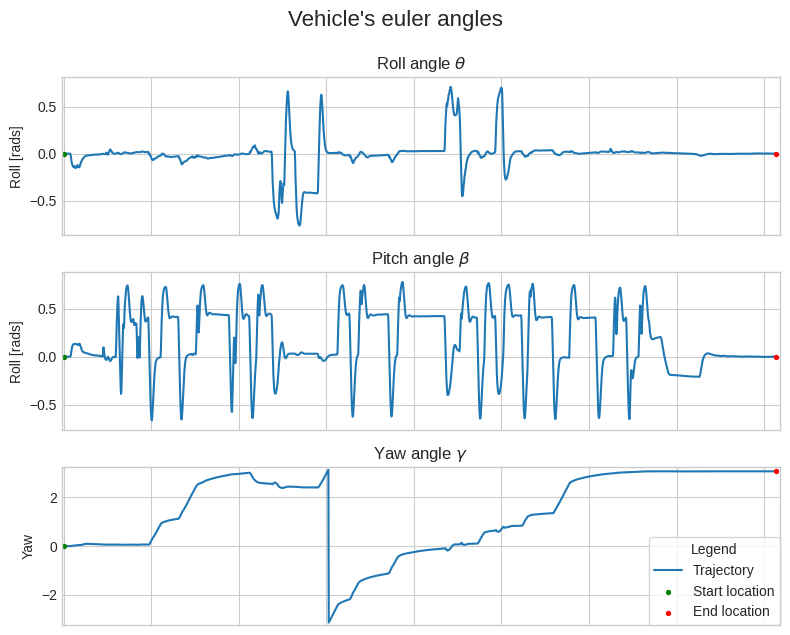

In [14]:
visualize_angles(orientation)

## Extract time stamp of each image 

In [42]:
time_list = []
images_list = []
for filename in glob.glob('images/test_1/*.jpeg'): #assuming gif
    img = cv2.imread(filename)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.basename(filename)
    # Split the time stamp of each image and save it in a list
    # nsecs is divided 1000000
    current_time = float(base_name.rsplit("secs_",2)[1].split('n')[0]) + float(base_name.rsplit("nsecs_",1)[1].split('.')[0])/1000000000
    time_list.append(current_time)
    images_list.append(image)
    
images_dict = dict(zip(time_list, images_list))

In [75]:
import collections

# Fix the time stamp to seconds
sorted_images = collections.OrderedDict(sorted(images_dict.items()))

# Obtain a list of timestamps
list_values = [t for t in sorted_images.keys()]
# Obtain minimum to set zero time
min_time = np.floor(np.amin(list_values))

# Create a new list with the final time stamps
sorted_images = dict([(t - min_time, i) for t, i in sorted_images.items()])

sorted_images.keys()

dict_keys([0.9420000000000073, 1.0419999999999163, 1.1419999999998254, 1.2420000000001892, 1.3420000000000982, 1.4420000000000073, 1.5419999999999163, 1.6460000000001855, 1.7420000000001892, 1.8420000000000982, 1.9420000000000073, 2.0419999999999163, 2.1419999999998254, 2.242000000000189, 2.3420000000000982, 2.4420000000000073, 2.5419999999999163, 2.6419999999998254, 2.742000000000189, 2.8420000000000982, 2.9420000000000073, 3.0419999999999163, 3.1419999999998254, 3.242000000000189, 3.3420000000000982, 3.4420000000000073, 3.5419999999999163, 3.6419999999998254, 3.7460000000000946, 3.8420000000000982, 3.9420000000000073, 4.041999999999916, 4.141999999999825, 4.242000000000189, 4.342000000000098, 4.442000000000007, 4.545999999999822, 4.6460000000001855, 4.742000000000189, 4.842000000000098, 4.942000000000007, 5.041999999999916, 5.141999999999825, 5.242000000000189, 5.342000000000098, 5.442000000000007, 5.541999999999916, 5.641999999999825, 5.742000000000189, 5.842000000000098, 5.94200000

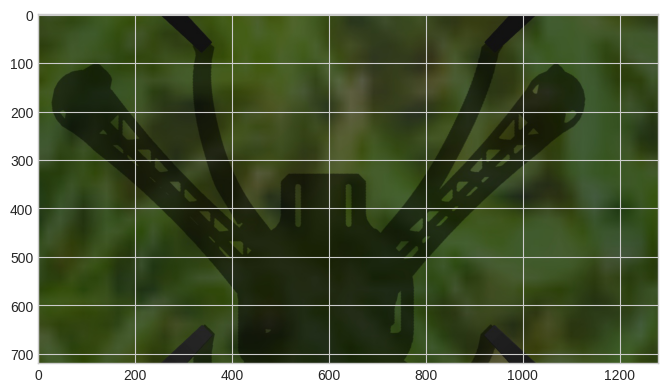

In [77]:
# Print an image

values_images = sorted_images.values()
images_iterator = iter(values_images)
first_value = next(images_iterator)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(first_value)

Camera calibration Matrix

In [25]:
K = np.array([[410., 0., 640.], [0., 410., 360.], [0., 0., 1.]])
K

array([[410.,   0., 640.],
       [  0., 410., 360.],
       [  0.,   0.,   1.]])

Rotation matrix between IMU and Camera $\boldsymbol{c}_{ic}$

\begin{equation}
    \boldsymbol{c}_{ic} = \begin{pmatrix} 0 & -1 & 0 \\ -1 & 0 & 0 \\  0 & 0 & -1 \end{pmatrix}
\end{equation}

And traslation $\boldsymbol{r}_i^{ci}$

\begin{equation}
    r_i^{ci} = \begin{bmatrix} 0 \\ 0 \\ 0.013633 \end{bmatrix}
\end{equation}

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 2765
        nsecs:  37000000
      frame_id: "map"
    child_frame_id: "base_link"
    transform: 
      translation: 
        x: -0.00670003006235
        y: -0.010315512307
        z: 0.0546470023692
      rotation: 
        x: 0.00960648755251
        y: -0.0136065109309
        z: 0.0327849376386
        w: -0.999323694555

transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 3023
        nsecs: 901060183
      frame_id: "map"
    child_frame_id: "base_link"
    transform: 
      translation: 
        x: 0.0388333983719
        y: -0.00901451800019
        z: 0.261256337166
      rotation: 
        x: 0.00733092832885
        y: -0.0166812376226
        z: 0.0343674675065
        w: -0.999243194074
        
transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 2761
        nsecs: 777000000
      frame_id: "map"
    child_frame_id: "base_link"
    transform: 
      translation: 
        x: 0.0352812968194
        y: 0.00332412286662
        z: 0.0406950972974
      rotation: 
        x: 0.0110811183601
        y: -0.0204384523481
        z: 0.0349244381095
        w: -0.999119493073

        
transforms: 
  - 
    header: 
      seq: 0
      stamp: 
        secs: 2755
        nsecs: 573000000
      frame_id: "base_link"
    child_frame_id: "camera_quad_f450_link"
    transform: 
      translation: 
        x: 0.0
        y: 0.0
        z: -0.013633
      rotation: 
        x: -0.707105258311
        y: 0.707107855658
        z: 0.000563089051367
        w: -0.00056308698303


In [15]:
# testing the results with ROS
c = Quaternion(w=-0.00056308698303, x=-0.707105258311, y=0.707107855658, z=0.000563089051367)
c.to_mat()

array([[-3.67320451821751e-06, array([-0.99999873]),
        array([-0.00159265])],
       [array([-1.]), 3.6731998596106763e-06, array([5.85013925e-09])],
       [array([6.35017212e-16]), array([0.00159265]),
        -0.9999987317280908]], dtype=object)

In [26]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    ### START CODE HERE ### 
    
    # Create SURF object. You can specify params here or later.
    # Here I set Hessian Threshold to 400
    
    # set extended to true to extract 128-dim descriptors.
    
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 600, nOctaves = 4, nOctaveLayers = 3, extended = True)
    
    kp, des = surf.detectAndCompute(image,None)  
    
    #Prints the amount of descriptors obtained
    #print('The coordinates of the first point is:')
    #print( kp[0].pt )
    #print('The descriptor shape is: ')
    #print( des.shape )

    
    ### END CODE HERE ###
    
    return kp, des

In [27]:
i = 0
image = dataset_handler.images[i]
kp, des = extract_features(image)
print("Number of features detected in frame {0}: {1}\n".format(i, len(kp)))

print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp[0].pt)))

NameError: name 'dataset_handler' is not defined

In [28]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.imshow(display)

In [29]:
# Optional: visualizing and experimenting with various feature descriptors
i = 0
image = dataset_handler.images_rgb[i]

visualize_features(image, kp)

NameError: name 'dataset_handler' is not defined

In [30]:
def extract_features_dataset(images, extract_features_function):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []
    
    ### START CODE HERE ###
    
    for i in range(dataset_handler.num_frames):
        kp, des = extract_features_function(images[i])
        kp_list.append(kp)
        des_list.append(des)

    
    ### END CODE HERE ###
    print(len(kp_list))
    print(len(des_list))
    
    return kp_list, des_list

In [31]:
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

NameError: name 'dataset_handler' is not defined

In [32]:
def match_features(des1, des2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    
    # BFMatcher with default params
    bf = cv.BFMatcher()
    match = bf.knnMatch(des1,des2, k=2)
    
    ### END CODE HERE ###

    return match

In [33]:
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))
#print(match[0][0].distance)
#print(match[0][1].distance)
# Remember that a matcher finds the best matches for EACH descriptor from a query set

NameError: name 'des_list' is not defined

In [34]:
# Optional
def filter_matches_distance(match, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    
    print('The number of features before distance ratio application')
    
    print(len(match))
    
    ### START CODE HERE ###
    for m,n in match:
        if m.distance < dist_threshold*n.distance:
            filtered_match.append([m])
            
    #print(len(filtered_match))
    

    
    ### END CODE HERE ###

    return filtered_match

In [35]:
# Optional
i = 0 
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2)

dist_threshold = 0.3 #this has to be changed
filtered_match = filter_matches_distance(match, dist_threshold)

print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

NameError: name 'des_list' is not defined

In [36]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    # cv.drawMatchesKnn expects list of lists as matches.
    image_matches = cv2.drawMatchesKnn(image1,kp1,image2,kp2,match, None,flags=2)
    
    #image_matches = cv2.drawMatches(image1,kp1,image2,kp2,match ,None, flags=2) #, None,flags=2
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [37]:
# Visualize n first matches, set n to None to view all matches
# set filtering to True if using match filtering, otherwise set to False
n = 20
filtering = True

i = 0 
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]

match = match_features(des1, des2)
if filtering:
    dist_threshold = 0.3 #this has to be changed
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])    

NameError: name 'dataset_handler' is not defined

In [38]:
def match_features_dataset(des_list, match_features):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches = []
    
    ### START CODE HERE ###
    for i in range(dataset_handler.num_frames - 1):
        des1 = des_list[i]
        des2 = des_list[i + 1]
        #Features matcher 
        match = match_features(des1, des2)
        #Append matches
        matches.append(match)

    
    ### END CODE HERE ###
    
    return matches

In [39]:
dist_threshold = 0.3 #this has to be changed
matches = match_features_dataset(des_list, match_features)
i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

NameError: name 'des_list' is not defined

In [40]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset. 
                        Each matches[i] is a list of good matches, satisfying the distance threshold
               
    """
    filtered_matches = []
    
    ### START CODE HERE ###
    for i in range(len(matches)):
        match = filter_matches_distance(matches[i], dist_threshold)
        filtered_matches.append(match)


    ### END CODE HERE ###
    
    return filtered_matches

In [41]:
# Optional
dist_threshold = 0.3 #this has to be changed

filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)

if len(filtered_matches) > 0:
    
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = True
    if is_main_filtered_m: 
        matches = filtered_matches

    i = 0
    print("Number of filtered matches in frames {0} and {1}: {2}".format(i, i+1, len(filtered_matches[i])))

NameError: name 'matches' is not defined

In [42]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    ### START CODE HERE ###
    
    #this for acced to each ROW of the descriptor vector e.g (240 x 180) and extract relevant information from each row
    for m in match:
        #m is a list of one position, to acced to it i have to do m[0]
        m = m[0]
        query_idx = m.queryIdx #This is the first image indexes
        train_idx = m.trainIdx #This is the second image indexes
        
        # https://stackoverflow.com/questions/10765066/what-is-query-and-train-in-opencv-features2d
        
        # get first img 3d data (with depth)
        p1_x, p1_y = kp1[query_idx].pt
        image1_points.append([p1_x, p1_y])
        
        # get second img 2d data
        p2_x, p2_y = kp2[train_idx].pt
        image2_points.append([p2_x, p2_y])

    # essential matrix use LMEDS instead of RANSAC
    E, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), dataset_handler.k)
    # use decomposeEssentialMat
    _, R, t, mask = cv2.recoverPose(E, np.array(image1_points), np.array(image2_points), dataset_handler.k)
    
    rmat = R
    tvec = t
        

    ### END CODE HERE ###
    
    return rmat, tvec, image1_points, image2_points

In [43]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]
rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

NameError: name 'matches' is not defined

In [44]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

NameError: name 'dataset_handler' is not defined

In [45]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
    trajectory = [np.array([0, 0, 0])]
    P = np.eye(4)
    
    ### START CODE HERE ###
    for i in range(len(matches)):
        #Extract relevant information of the matches, and features from image i to i + 1
        match = matches[i]
        kp1 = kp_list[i]
        kp2 = kp_list[i+1]
        depth = depth_maps[i]

        rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth)
        R = rmat
        t = np.array([tvec[0,0],tvec[1,0],tvec[2,0]])
        
        P_new = np.eye(4) #New P Matrix
        P_new[0:3,0:3] = R.T #Rotated rotation matrix to point from the world to camera and change it to camera - world
        P_new[0:3,3] = (-R.T).dot(t) #Translation vector to point from image plane to world plane frames
        P = P.dot(P_new) #Dot product to add the matrices

        trajectory.append(P[:3,3])

    trajectory = np.array(trajectory).T #this gives a 3 x 52 matrix
    #print(trajectory[:,0])
    #print('With negative z')
    #trajectory[2,:] = -1*trajectory[2,:]
    #print((trajectory[:,0]))
    #print('Step changed')
     
        
        
    ### END CODE HERE ###
    
    return trajectory

In [46]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

NameError: name 'dataset_handler' is not defined

In [47]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 0.75
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches

    
# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

NameError: name 'dataset_handler' is not defined